## 3. Gradient Boosted Trees XGBoost

1. Trees for defaults

You will now train a gradient boosted tree model on the credit data, and see a sample of some of the predictions. Do you remember when you first looked at the predictions of the logistic regression model? They didn't look good. Do you think this model be different?

In [1]:
# Import pandas as pd
import pandas as pd
import matplotlib as mtlb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb

In [2]:
# Read in the csv file
clean_loan_data = pd.read_csv('clean_loan_data.csv')

In [3]:
# Create two data sets for numeric and non-numeric data
cred_num = clean_loan_data.select_dtypes(exclude=['object'])
cred_str = clean_loan_data.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

In [4]:
# Create the X and y data sets
X = cr_loan_prep.drop(['loan_status'], axis=1)
y = cr_loan_prep[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [5]:
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
gbt_preds = clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['prob_default'])
true_df = y_test

# Concatenate and print the two data frames for comparison
#print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

2. Gradient boosted portfolio performance

At this point you've looked at predicting probability of default using both a LogisticRegression() and XGBClassifier(). You've looked at some scoring and have seen samples of the predictions, but what is the overall affect on portfolio performance? Try using expected loss as a scenario to express the importance of testing different models.

A data frame called portfolio has been created to combine the probabilities of default for both models, the loss given default (assume LGD 20% for now), and the loan_amnt which will be assumed to be the exposure at default.

In [6]:
lr_prob_default = pd.read_csv('logreg_prob_default.csv')
print(len(lr_prob_default))
print(len(preds_df))

11784
11784


In [7]:
portfolio=pd.DataFrame()
#portfolio['gbt_prob_default']=preds_df
portfolio=preds_df
portfolio['lr_prob_default']=lr_prob_default
portfolio['loan_amnt']=cr_loan_prep[['loan_amnt']]
portfolio['lgd']=0.2
print(portfolio.head(2))

   prob_default  lr_prob_default  loan_amnt  lgd
0      0.990942         0.445779       1000  0.2
1      0.983987         0.223447       5500  0.2


In [8]:
print(portfolio.head(5))

# Create expected loss columns for each model using the formula
portfolio['gbt_expected_loss'] = portfolio['prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']
portfolio['lr_expected_loss'] = portfolio['lr_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']

# Print the sum of the expected loss for lr
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss']))

# Print the sum of the expected loss for gbt
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))

   prob_default  lr_prob_default  loan_amnt  lgd
0      0.990942         0.445779       1000  0.2
1      0.983987         0.223447       5500  0.2
2      0.000807         0.288558      35000  0.2
3      0.001239         0.169358      35000  0.2
4      0.084892         0.114182       2500  0.2
LR expected loss:  4752523.770084315
GBT expected loss:  4407645.7586168


3. Assessing gradient boosted trees

So you've now used XGBClassifier() models to predict probability of default. These models can also use the .predict() method for creating predictions that give the actual class for loan_status.

You should check the model's initial performance by looking at the metrics from the classification_report(). Keep in mind that you have not set thresholds for these models yet.

In [9]:
# Predict the labels for loan status
gbt_preds = clf_gbt.predict(X_test)

# Check the values created by the predict method
print(gbt_preds)

# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(metrics.classification_report(y_test, gbt_preds, target_names=target_names))

[1 1 0 ... 0 0 0]
              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.94      0.74      0.83      2586

    accuracy                           0.93     11784
   macro avg       0.94      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784



4. Column importance and default prediction

When using multiple training sets with many different groups of columns, it's important to keep and eye on which columns matter and which do not. It can be expensive or time-consuming to maintain a set of columns even though they might not have any impact on loan_status.

The X data for this exercise was created with the following code:

X = cr_loan_prep[['person_income','loan_int_rate',
                  'loan_percent_income','loan_amnt',
                  'person_home_ownership_MORTGAGE','loan_grade_F']]
Train an XGBClassifier() model on this data, and check the column importance to see how each one performs to predict loan_status.

In [12]:
X = cr_loan_prep[['person_income','loan_int_rate', 'loan_percent_income','loan_amnt', 'person_home_ownership_MORTGAGE','loan_grade_F']]
y = cr_loan_prep[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

In [13]:
# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

{'loan_percent_income': 515, 'loan_int_rate': 1001, 'person_income': 1299, 'loan_amnt': 519, 'person_home_ownership_MORTGAGE': 116, 'loan_grade_F': 9}


5. Visualizing column importance

When the model is trained on different sets of columns it changes the performance, but does the importance for the same column change depending on which group it's in?

The data sets X2 and X3 have been created with the following code:

X2 = cr_loan_prep[['loan_int_rate','person_emp_length']] <br>
X3 = cr_loan_prep[['person_income','loan_int_rate','loan_percent_income']] <br>
Understanding how different columns are used to arrive at a loan_status prediction is very important for model interpretability.

In [14]:
X2 = cr_loan_prep[['loan_int_rate','person_emp_length']]
X3 = cr_loan_prep[['person_income','loan_int_rate','loan_percent_income']]

# Use test_train_split to create the training and test sets
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)

# Use test_train_split to create the training and test sets
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=.4, random_state=123)


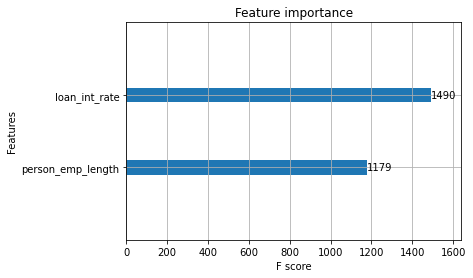

In [15]:
# Train a model on the X data with 2 columns
clf_gbt2 = xgb.XGBClassifier().fit(X2_train,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt2, importance_type = 'weight')
plt.show()

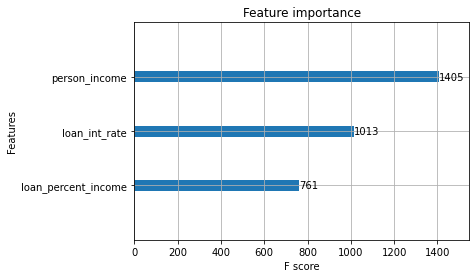

In [16]:
# Train a model on the X data with 3 columns
clf_gbt3 = xgb.XGBClassifier().fit(X3_train,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt3, importance_type = 'weight')
plt.show()

6. Column selection and model performance

Creating the training set from different combinations of columns affects the model and the importance values of the columns. Does a different selection of columns also affect the F-1 scores, the combination of the precision and recall, of the model? You can answer this question by training two different models on two different sets of columns, and checking the performance.

Inaccurately predicting defaults as non-default can result in unexpected losses if the probability of default for these loans was very low. You can use the F-1 score for defaults to see how the models will accurately predict the defaults.

The credit data, cr_loan_prep and the two training column sets X and X2 have been loaded in the workspace. The models gbt and gbt2 have already been trained.

In [19]:
# Predict the loan_status using each model
gbt_preds = clf_gbt.predict(X_test)
gbt2_preds = clf_gbt2.predict(X2_test)

# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(metrics.classification_report(y_test, gbt_preds, target_names=target_names))

# Print the classification report of the second model
print(metrics.classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.91      0.95      0.93      9198
     Default       0.81      0.66      0.73      2586

    accuracy                           0.89     11784
   macro avg       0.86      0.81      0.83     11784
weighted avg       0.89      0.89      0.89     11784

              precision    recall  f1-score   support

 Non-Default       0.83      0.96      0.89      9198
     Default       0.67      0.29      0.40      2586

    accuracy                           0.81     11784
   macro avg       0.75      0.62      0.65     11784
weighted avg       0.79      0.81      0.78     11784

